In [6]:
%load_ext autoreload
%autoreload 2

import ncxt_sxtcnn
from ncxt_sxtcnn.pipe import NCXTPipe


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
folder = 'mockdata/'
wd = "c:/Users/axela/Documents/2021/ncxt_sxtcnn/"
organelles = ['cell','nucleus']

processor_args = {"block_shape": [32, 32, 32], "binning": 1, "n_blocks": 8}
model_args = {"instancenorm": True, "depth": 4}
settings = {"maximum_iterations": 100}

In [27]:
pipe = NCXTPipe(
    folder=folder,
    working_directory=wd,
    organelles=organelles,
    fold=0,
    processor_args=processor_args,
    model_args=model_args,
    settings=settings,
)
pipe.dataframe()

WARNING  [project.py:94] find data
WARNING  [project.py:94] find data


Files 2 + 0


,project,sample,hxpath,void,void1,nucleus,nucleolus,granule,mitochondria,lipid,endoplasmic reticulum,membrane,ignore
0,pi1,sample_12,mockdata\pi1\sample_12.hx,0,1.0,2,3,4.0,5,6,7,8,9.0
1,pi2,sample_9,mockdata\pi2\sample_9.hx,0,,1,5,,3,2,4,6,


  0%|          | 0/2 [00:00<?, ?it/s]

WARNING  [project.py:94] find data
WARNING  [project.py:94] find data


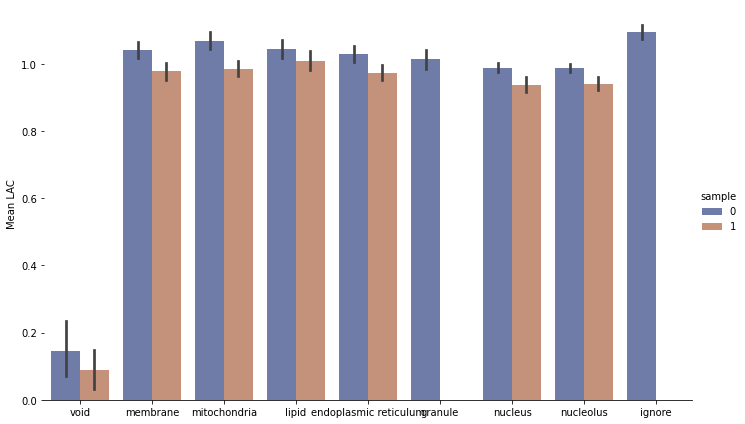

In [28]:
pipe.check_database()

WARNING  [project.py:94] find data
WARNING  [project.py:94] find data


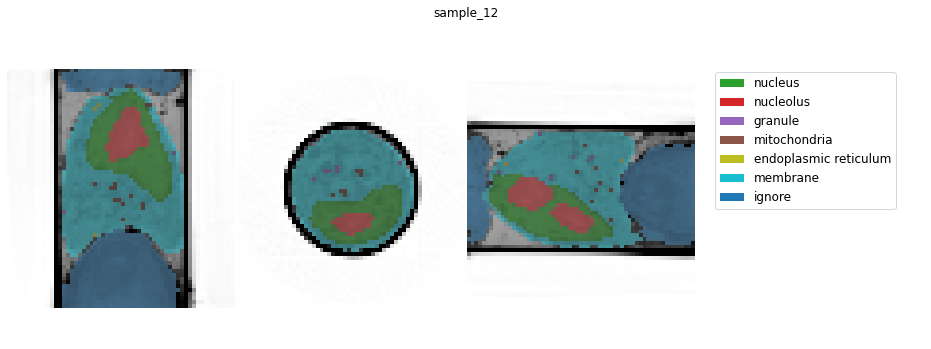

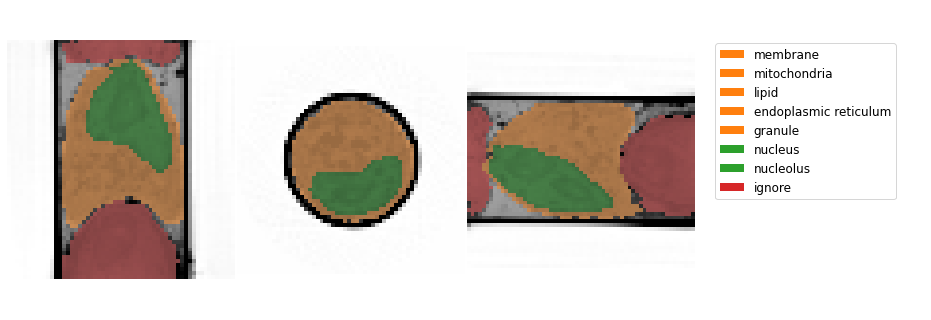

In [29]:
pipe.check_loader(0)

WARNING  [project.py:94] find data
WARNING  [project.py:94] find data
WARNING  [project.py:94] find data
WARNING  [project.py:94] find data


Missing file c:\Users\axela\Documents\2021\ncxt_sxtcnn\data42955/11976_state.npy
State not found, training


  0%|          | 0/100 [00:00<?, ?it/s]

model 11976 {'name': 'UNet3D', 'training': True, 'up_mode': 'transpose', 'num_classes': 3, 'in_channels': 1, 'start_filts': 32, 'dropout': 0, 'instancenorm': True, 'dirichlet': False, 'depth': 4}
model 11976 {'name': 'UNet3D', 'training': True, 'up_mode': 'transpose', 'num_classes': 3, 'in_channels': 1, 'start_filts': 32, 'dropout': 0, 'instancenorm': True, 'dirichlet': False, 'depth': 4}


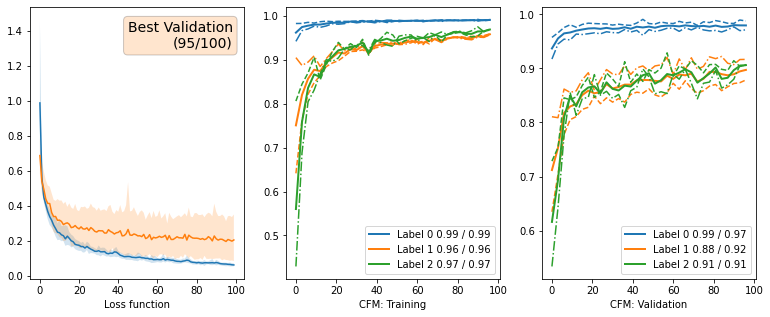

In [30]:
pipe.plot_train()

In [1]:
import os
import sys
import tempfile
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP

# On Windows platform, the torch.distributed package only
# supports Gloo backend, FileStore and TcpStore.
# For FileStore, set init_method parameter in init_process_group
# to a local file. Example as follow:
# init_method="file:///f:/libtmp/some_file"
# dist.init_process_group(
#    "gloo",
#    rank=rank,
#    init_method=init_method,
#    world_size=world_size)
# For TcpStore, same way as on Linux.

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

In [2]:
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = nn.Linear(10, 10)
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(10, 5)

    def forward(self, x):
        return self.net2(self.relu(self.net1(x)))


def demo_basic(rank, world_size):
    print(f"Running basic DDP example on rank {rank}.")
    setup(rank, world_size)

    # create model and move it to GPU with id rank
    model = ToyModel().to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(rank)
    loss_fn(outputs, labels).backward()
    optimizer.step()

    cleanup()


def run_demo(demo_fn, world_size):
    mp.spawn(demo_fn,
             args=(world_size,),
             nprocs=world_size,
             join=True)
run_demo(demo_basic, 2)


ProcessExitedException: process 0 terminated with exit code 1